<a href="https://colab.research.google.com/github/MatthewChiu/Chord_embeddings_for_stylistic_analysis/blob/main/ChordEmbeddingsForAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **South Central Society for Music Theory**

---


Matt Chiu /
email: mchiu9@u.rochester.edu

The code here is single use. More functions would be needed for general application. 

# **Uploading YCAC CSV**

In [ ]:
# Put Mozart files here. This takes quite a long time...
from google.colab import files
uploaded = files.upload()

Saving MozartSlices.csv to MozartSlices.csv


In [ ]:
# function for retrieving data from YCAC
import io
import pandas as pd

def getPitchInformation(csvFile):
  composerDF = pd.read_csv(io.BytesIO(uploaded[csvFile]))
  composerSelected = composerDF[["offset","Composer","file","PCsInNormalForm", "GlobalScaleDegrees","LocalSDForm_BassSD","LocalTonic","Confidence"]]
  arrayOfPCFromPieces = []
  arrayOfGSD = []
  arrayOfLSD = []
  arrayOfPieces = []
  arrayOfComposers = []
  arrayOfLocalKey = []
  arrayOfOffsets = []
  pieceCounter = -1
  for counter, chord in enumerate(composerSelected["PCsInNormalForm"]):
    if composerSelected["file"][counter] not in arrayOfPieces:
      arrayOfPieces.append(composerSelected["file"][counter])
      arrayOfComposers.append(composerSelected["Composer"][counter])
      arrayOfPCFromPieces.append([])
      arrayOfGSD.append([])
      arrayOfLSD.append([])
      arrayOfLocalKey.append([])
      arrayOfOffsets.append([])
      pieceCounter+=1
    arrayOfPCFromPieces[pieceCounter].append(chord)
    arrayOfGSD[pieceCounter].append(composerSelected["GlobalScaleDegrees"][counter])
    arrayOfLSD[pieceCounter].append(composerSelected["LocalSDForm_BassSD"][counter])
    arrayOfLocalKey[pieceCounter].append(composerSelected["LocalTonic"][counter])
    arrayOfOffsets[pieceCounter].append(composerSelected["offset"][counter])
  return arrayOfPieces, arrayOfPCFromPieces, arrayOfGSD, arrayOfLSD, arrayOfComposers, arrayOfLocalKey

In [ ]:
MozartPitches = getPitchInformation("MozartSlices.csv")

# **Key-lime formatting**



In [ ]:
# Tonic keys are represented as int 12–23
import re
listOfChordsWithKeys = []
for counter1, piece in enumerate(MozartPitches[1]):
  listOfChordsWithKeys.append([])
  for counter2, chord in enumerate(piece):
    pitchesInChord = re.findall(r'\d+', chord)
    if MozartPitches[5][counter1][counter2]=="Ambiguous":
      localTonicInt = []
    else:
      localTonicInt = [int(re.findall(r'\d+', MozartPitches[5][counter1][counter2])[0])+12]

    listOfChordsWithKeys[counter1].append(str(pitchesInChord+localTonicInt))

# **Building the Mozart Model**



In [ ]:
from gensim.models import Word2Vec
# Parameters corpus, window size, minimum occurence, vector size, skip-gram (binary{1,0}), iterations, organization
mozartModel2 = Word2Vec(listOfChordsWithKeys, window = 4, min_count = 1, size = 30, sg = 1, iter = 40, sorted_vocab=1)

# ***Distance from C***

In [ ]:
listOfPotentialChords = ["['0', '4', '7', 12]", "['1', '5', '8', 13]", "['2', '6', '9', 14]", "['3', '7', '10', 15]", "['4', '8', '11', 16]", "['5', '9', '0', 17]", "['6', '10', '1', 18]"\
                         , "['7', '11', '2', 19]", "['8', '0', '3', 20]", "['9', '1', '4', 21]", "['10', '2', '5', 22]", "['11', '3', '6', 23]"] 

In [ ]:
listOfDiatonicChords = ["['0', '4', '7', 12]", "['2', '5', '9', 12]", "['4', '7', '11', 12]", "['5', '9', '0', 12]" \
                         , "['7', '11', '2', 12]", "['9', '0', '4', 12]", "['11', '2', '5', 12]"] 

In [ ]:
# Uncomment "listOfPot..." for key relationships or "listOfDia..." for list of diatonic relationships

cosineDistanceMatrix = []
# for counter, firstChord in enumerate(listOfPotentialChords):
for counter, firstChord in enumerate(listOfDiatonicChords):
  # print(firstChord)
  cosineDistanceMatrix.append([])
  # for counter2, secondChord in enumerate(listOfPotentialChords):
  for counter2, secondChord in enumerate(listOfDiatonicChords):
    # print(secondChord)
    sim = mozartModel2.similarity(firstChord, secondChord)
    cosineDistanceMatrix[counter].append(sim)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [ ]:
# Plotting it for visualization

import matplotlib.pyplot as plt
import numpy as np

figure = plt.figure()
# labels = ["Db","D","Eb","E","F","F#","G","Ab","A","Bb","B"]
labels = ["Dm","Em","F","G","Am","Bdim"]
plt.plot(labels, cosineDistanceMatrix[0][1:12])
plt.show()


# **Key clustering**

In [ ]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage

newDendro = []
for word in mozartModel2.wv.vocab:
  if word in listOfPotentialChords:
    newDendro.append(mozartModel2[word])

wordVectors = newDendro
dendrogram = sch.dendrogram(sch.linkage(wordVectors, method  = "ward"))

import matplotlib.pyplot as plt
plt.title('Mozart Dendrogram')
plt.xlabel('Tonic Chords')
plt.ylabel('Euclidean distances')
plt.show()

# **Analyzing "Non siate ritrosi"**

In [ ]:
# n represents the indexed piece in the CSV file
pieceToAnalyze = listOfChordsWithKeys[15]
pieceName = MozartPitches[0][15]

# For example...
# Cosi fan tutte K588 No15 Aria "Non siate ritrosi" G major.mid - 15
# Piano Sonata K280 iii F major.mid - 866
# Symphony No 39 in Eb, K.543 iii Eb major.mid – 407
# Symphony No 38 in D, K.504 ('Prague') i D major.mid – 428

In [ ]:
Non_siate_ritrosi = listOfChordsWithKeys[15][0:65]

In [ ]:
# retrieve adjacent distances in Non siate
distanceOverPiece = []
for position, eachChord in enumerate(Non_siate_ritrosi):
  if position > 0:
    distanceMinus1 = 1-mozartModel2.similarity(eachChord, pieceToAnalyze[position-1])
    distanceOverPiece.append(distanceMinus1)

<Figure size 432x288 with 0 Axes>

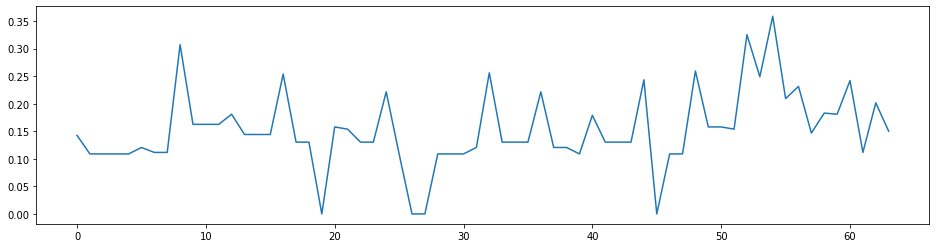

In [ ]:
# Plot the Mozart analysis
plt.figure()
fig, ax = plt.subplots(figsize=(16, 4))
plt.plot(distanceOverPiece)
plt.show()

# **Uploading and parsing rock corpus**

In [ ]:
# This is where you upload the rock corpus
from google.colab import files
uploaded = files.upload()

Saving rockCorpusChord.txt to rockCorpusChord.txt


In [ ]:
fileName = "rockCorpusChord.txt"
rs_parsed = uploaded[fileName].decode("utf-8").split("\n")

In [ ]:
# Includes all information
pitchesSortedByPiece = []

# Includes pitch names
piecesSortedByName = []

# includes PCs
chordsSortedByPiece = []

counter = -1
for element in rs_parsed:
  if element.startswith("%"):
    piecesSortedByName.append(element)
    chordsSortedByPiece.append([]) 
    counter+=1
    continue
  elif element.startswith("---"):
    continue
  else:
    row = element.split()
    chordInRow = row[2]
    key = row[5]
    chordsSortedByPiece[counter].append(str([chordInRow, key]))

In [ ]:
chordCounter = 0
for piece in chordsSortedByPiece:
  for chord in piece:
    chordCounter+=1
    print(chord)
print(chordCounter)

# **Building the rock model**

In [ ]:
from gensim.models import Word2Vec

# Make it window = 3 for keys
rockModel = Word2Vec(chordsSortedByPiece, window = 2, min_count = 1, size = 20, sg = 1, iter = 100, sorted_vocab=1)

# **Distance from C**

In [ ]:
listOfDiatonicChords = ["['I', '0']", "['ii', '0']", "['iii', '0']", "['IV', '0']" \
                         , "['V', '0']", "['vi', '0']", "['bVII', '0']"] 

In [ ]:
# Diatonic chord distances

cosineDistanceMatrix = []
for counter, firstChord in enumerate(listOfDiatonicChords):
  cosineDistanceMatrix.append([])
  for counter2, secondChord in enumerate(listOfDiatonicChords):
    sim = rockModel.similarity(firstChord, secondChord)
    cosineDistanceMatrix[counter].append(sim)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  if __name__ == '__main__':


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

figure = plt.figure()
labels = ["Dm","Em","F","G","Am","Bb"]
plt.plot(labels, cosineDistanceMatrix[0][1:12])

# **Rock Analysis**

In [ ]:
pieceToAnalyze = chordsSortedByPiece[326][40:70]

# First index number is the selected piece:
# 308/309 – smells like teen spirit
# 326 – sweet child o' mine

In [ ]:
# calculating adjacent distances
distanceOverPiece = []
for position, eachChord in enumerate(smells_like_teen):
  if position > 0:
    distanceMinus1 = 1-rockModel.similarity(eachChord, pieceToAnalyze[position-1])
    distanceOverPiece.append(distanceMinus1)

<Figure size 432x288 with 0 Axes>

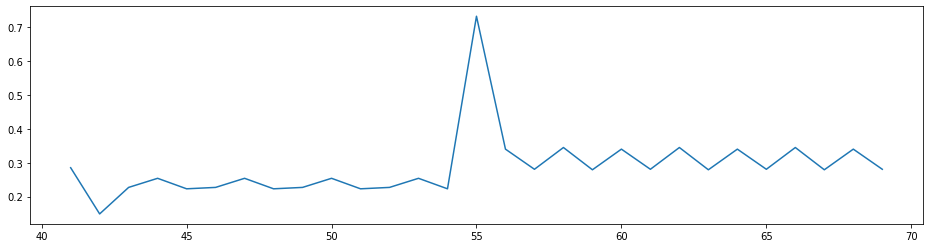

In [ ]:
plt.figure()

fig, ax = plt.subplots(figsize=(16, 4))
labels = range(41, 70)
plt.plot(labels, distanceOverPiece)
plt.show()

# **G+R Simulation for Mozart**

In [ ]:
# Simulating guns n' roses with Mozart embeddings

chordLoop = ["['7', '11', '2', 12]","['10', '2', '5', 12]", "['0', '4', '7', 12]"]
chordLoopx4 = (chordLoop*4)
soloLoop = ["['2', '5', '9', 14]","['10', '2', '5', 14]", "['9', '1', '4', 14]", "['7', '10', '2', 14]"]
soloLoopx4 = (soloLoop*4)
combinedExcerpt = ["['0', '4', '7', 12]"]+["['0', '4', '7', 12]"]+chordLoopx4+soloLoopx4

In [ ]:
# adjacent distances according to mozart
distanceOverPiece2 = []
for position, eachChord in enumerate(combinedExcerpt):
  if position > 0:
    distanceMinus1 = 1-mozartModel2.similarity(eachChord, combinedExcerpt[position-1])
    distanceOverPiece2.append(distanceMinus1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """


<Figure size 432x288 with 0 Axes>

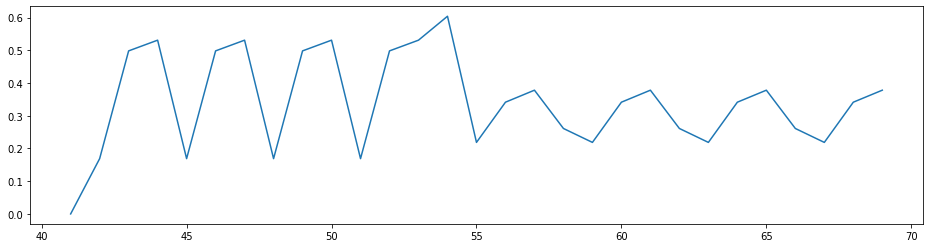

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(16, 4))
labels = range(41, 70)
plt.plot(labels, distanceOverPiece2)
plt.show()